## Using a pre-trained ConvNet

### Transfer Learning Scenarios

__1- Feature Extraction without Data Augmentation__  <br />
__2- Feature Extraction with Data Augmentation__ <br />
__3- Fine Tuning__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import os, shutil, tarfile

### Using VGG-16 pretrained Model

In [42]:
## taking the weights of ImageNet Dataset and take only the convBase, I will make my top classifier
from tensorflow.keras.applications import VGG16
## Load the Model
conv_base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [43]:
## check the summary 
conv_base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### Download the Dataset of dogs and cats from kaggle as we mentioned before using Kaggle API
``` bash
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c dogs-vs-cats
!unzip /content/train.zip
```

In [4]:
## I downlaod the data to my pc

original_dir = 'full_kaggle_dataset_dogs_cats'
base_dir = 'cats_dogs_dataset'

# check for directory
if not os.path.isdir(base_dir):
    os.makedirs(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# check for directory
if not os.path.isdir(train_dir):
    os.makedirs(train_dir)
# check for directory
if not os.path.isdir(valid_dir):
    os.makedirs(valid_dir)
# check for directory
if not os.path.isdir(test_dir):
    os.makedirs(test_dir)
    
# check for directory
if not os.path.isdir(train_cats_dir):
    os.makedirs(train_cats_dir)
# check for directory
if not os.path.isdir(train_dogs_dir):
    os.makedirs(train_dogs_dir)
# check for directory
if not os.path.isdir(valid_cats_dir):
    os.makedirs(valid_cats_dir)
# check for directory
if not os.path.isdir(valid_dogs_dir):
    os.makedirs(valid_dogs_dir)
# check for directory
if not os.path.isdir(test_cats_dir):
    os.makedirs(test_cats_dir)
# check for directory
if not os.path.isdir(test_dogs_dir):
    os.makedirs(test_dogs_dir)
    
    
# Copy first 1000 cat images to train_cats_dir
imgs_train = ['cat.{}.jpg'.format(i) for i in range(1000)]
for img in imgs_train:
    src = os.path.join(original_dir, img)
    dst = os.path.join(train_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy first 1000 dog images to train_dogs_dir
imgs_train = ['dog.{}.jpg'.format(i) for i in range(1000)]
for img in imgs_train:
    src = os.path.join(original_dir, img)
    dst = os.path.join(train_dogs_dir, img)
    shutil.copyfile(src, dst)
    
# Copy second 500 cat images to valid_cats_dir
imgs_valid = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for img in imgs_valid:
    src = os.path.join(original_dir, img)
    dst = os.path.join(valid_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy second 500 dog images to valid_dogs_dir
imgs_valid = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for img in imgs_valid:
    src = os.path.join(original_dir, img)
    dst = os.path.join(valid_dogs_dir, img)
    shutil.copyfile(src, dst)
    
# Copy second 500 cat images to test_cats_dir
imgs_test = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for img in imgs_test:
    src = os.path.join(original_dir, img)
    dst = os.path.join(test_cats_dir, img)
    shutil.copyfile(src, dst)
# Copy second 500 dog images to test_dogs_dir
imgs_test = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for img in imgs_test:
    src = os.path.join(original_dir, img)
    dst = os.path.join(test_dogs_dir, img)
    shutil.copyfile(src, dst)    ## data is ready

### Feature Extraction without Data Augmentation
` Note that conv_base_vgg16 --> extract Features (4, 4, 512)`

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
n_batch_size = 20

def extract_features(req_directory, req_sample_count):
    ## empty array for both features and label
    features = np.zeros((req_sample_count, 4, 4, 512))
    labels = np.zeros(req_sample_count)
    
    generator_dir = datagen.flow_from_directory(directory=req_directory, target_size=(150, 150), 
                                                class_mode='binary', batch_size=n_batch_size, 
                                                color_mode='rgb', shuffle=True)  
    i = 0
    for inputs_batch, labels_batch in generator_dir:
        features_batch = conv_base_vgg16.predict(inputs_batch)
        ## fill the empty arrays
        features[i*n_batch_size:(i+1)*n_batch_size] = features_batch
        labels[i*n_batch_size:(i+1)*n_batch_size] = labels_batch
        
        i += 1
        
        ## break after full batch_size --> because generator yields does not stop
        if i * n_batch_size >= req_sample_count:
            break
        
    return features, labels

In [8]:
## call the function to extract features and labels for (train, valid, test)
## as mentioned before --> using only 1000/class for train, 500/class for both valid and test
train_features, train_labels = extract_features(req_directory=train_dir, req_sample_count=2000)
valid_features, valid_labels = extract_features(req_directory=valid_dir, req_sample_count=1000)
test_features, test_labels = extract_features(req_directory=test_dir, req_sample_count=1000)

## check shape
print('train_features shape ...', train_features.shape)
print('train_labels shape ...', train_labels.shape)
print('valid_features shape ...', valid_features.shape)
print('valid_labels shape ...', valid_labels.shape)
print('test_features shape ...', test_features.shape)
print('test_labels shape ...', test_labels.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
train_features shape ... (2000, 4, 4, 512)
train_labels shape ... (2000,)
valid_features shape ... (1000, 4, 4, 512)
valid_labels shape ... (1000,)
test_features shape ... (1000, 4, 4, 512)
test_labels shape ... (1000,)


##### `Very Important Point ---> you MUST Flatten the features as you will pass them to Dense directly `

In [9]:
## reshape train_features, valid_features, test_features
## reshaping will be to (batch_count x product)    #------> Note that
train_features = np.reshape(train_features, (2000, 4*4*512))
valid_features = np.reshape(valid_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

## check the shape now

## check shape
print('train_features shape ...', train_features.shape)
print('train_labels shape ...', train_labels.shape)
print('valid_features shape ...', valid_features.shape)
print('valid_labels shape ...', valid_labels.shape)
print('test_features shape ...', test_features.shape)
print('test_labels shape ...', test_labels.shape)   ## ready to enter the model

train_features shape ... (2000, 8192)
train_labels shape ... (2000,)
valid_features shape ... (1000, 8192)
valid_labels shape ... (1000,)
test_features shape ... (1000, 8192)
test_labels shape ... (1000,)


#### Build the Model

In [10]:
model_extract = tf.keras.models.Sequential([
    ## we add only the top classifier --> 
    ## as our inputs to the model are 4x4x512 (extracted features already)
    tf.keras.layers.Dense(256, activation='relu', input_shape=(4*4*512,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')   ## binary
])

model_extract.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])
early_stopp = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

history_extract = model_extract.fit(train_features, train_labels, 
                                    validation_data=(valid_features, valid_labels), 
                                    epochs=50, batch_size=20, callbacks=[early_stopp])

Epoch 1/50
100/100 [==============================] - 1s 9ms/step - loss: 0.4805 - accuracy: 0.7550 - val_loss: 0.2995 - val_accuracy: 0.8760
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.2932 - accuracy: 0.8845 - val_loss: 0.2731 - val_accuracy: 0.8880
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.2358 - accuracy: 0.9035 - val_loss: 0.2405 - val_accuracy: 0.9050
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 0.2034 - accuracy: 0.9165 - val_loss: 0.2956 - val_accuracy: 0.8690
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 0.1732 - accuracy: 0.9365 - val_loss: 0.2527 - val_accuracy: 0.8990
Epoch 6/50
100/100 [==============================] - 1s 7ms/step - loss: 0.1601 - accuracy: 0.9385 - val_loss: 0.2876 - val_accuracy: 0.8810
Epoch 7/50
100/100 [==============================] - 1s 8ms/step - loss: 0.1375 - accuracy: 0.9415 - val_loss: 0.2564 - val_accuracy: 0.8970
Epoch 

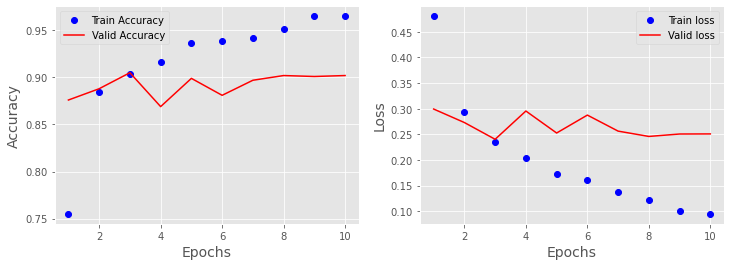

In [17]:
## Visualize the resutls
n_epochs = len(history_extract.history['accuracy'])

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history_extract.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history_extract.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history_extract.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history_extract.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [11]:
## evaluating on test set
loss_test, acc_test = model_extract.evaluate(test_features, test_labels)
print('loss_test -->', loss_test)
print('acc_test -->', acc_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.2607 - accuracy: 0.8870
loss_test --> 0.2607244849205017
acc_test --> 0.8870000243186951


### Feature Extractinon with Data Augmentation

In [12]:
## Build a Model but add the conv_base to it

model_extract_aug = tf.keras.models.Sequential([
                        conv_base_vgg16,    ## Add the conv_base
                        ## Do not forget to flatten
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(256, activation='relu'),
                        tf.keras.layers.Dense(1, activation='sigmoid')
])

model_extract_aug.summary()  ## very nice

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
## check trainable weights
## for each conv or dense --> 1 for weight and 1 for bias --> you can calculate 30
print('Number of trainable weights before freezing -->', len(model_extract_aug.trainable_weights))

conv_base_vgg16.trainable = False    ###  --> Freezing the model to be as it is

print('Number of trainable weights after freezing -->', len(model_extract_aug.trainable_weights))

Number of trainable weights before freezing --> 30
Number of trainable weights after freezing --> 4


__Please take care of the parameter: process_input in ImageDataGenerator class.__
This one is important as it performs the necessary preprocessing needed for the image before giving it to the model you transfer from.
Every pre-trained net typically provides the good pre-processing function.

For VGG16: keras.applications.vgg16.preprocess_input
It's also ok to use from keras.applications.imagenet_utils import preprocess_input in case of VGG

In [14]:
### we can do Augmentation now
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
                           rescale=1./255,   
        ## use VGG16 function for processing --> check this function (not divide by 255)
                           preprocessing_function=preprocess_input, 
                           rotation_range=40, 
                            width_shift_range=0.2, 
                            height_shift_range=0.2, 
                            shear_range=0.2, 
                            zoom_range=0.2, 
                            horizontal_flip=True, 
                            fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

## craete the Generators for train, valid and test

## only Augmentation for training Data ---> so only train_datagen
train_gen = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(150, 150), 
                                                    color_mode='rgb',  batch_size=20, 
                                                    class_mode='binary')
## only Augmentation for training Data ---> so only train_datagen
valid_gen = test_datagen.flow_from_directory(directory=valid_dir, 
                                                    target_size=(150, 150), 
                                                    color_mode='rgb',  batch_size=20, 
                                                    class_mode='binary')
## only Augmentation for training Data ---> so only train_datagen
test_gen = test_datagen.flow_from_directory(directory=test_dir, 
                                                    target_size=(150, 150), 
                                                    color_mode='rgb',  batch_size=20, 
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
## train the model
model_extract_aug.compile(loss='binary_crossentropy', 
                          optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), 
                          metrics=['accuracy'])

## Here Generator ---> it will loop forever --> specity steps for training and validation
history_extract_aug = model_extract_aug.fit(train_gen, validation_data=(valid_gen), 
                                            steps_per_epoch=100, validation_steps=50,
                                            epochs=30, batch_size=20)

Epoch 1/30
100/100 [==============================] - 22s 217ms/step - loss: 0.5824 - accuracy: 0.7035 - val_loss: 0.4103 - val_accuracy: 0.8440
Epoch 2/30
100/100 [==============================] - 22s 216ms/step - loss: 0.4553 - accuracy: 0.8050 - val_loss: 0.3252 - val_accuracy: 0.8790
Epoch 3/30
100/100 [==============================] - 21s 206ms/step - loss: 0.3937 - accuracy: 0.8310 - val_loss: 0.3094 - val_accuracy: 0.8640
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3706 - accuracy: 0.8350 - val_loss: 0.2710 - val_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3650 - accuracy: 0.8350 - val_loss: 0.2645 - val_accuracy: 0.8900
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3317 - accuracy: 0.8485 - val_loss: 0.2554 - val_accuracy: 0.8870
Epoch 7/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3273 - accuracy: 0.8525 - val_loss: 0.2582 - val_ac

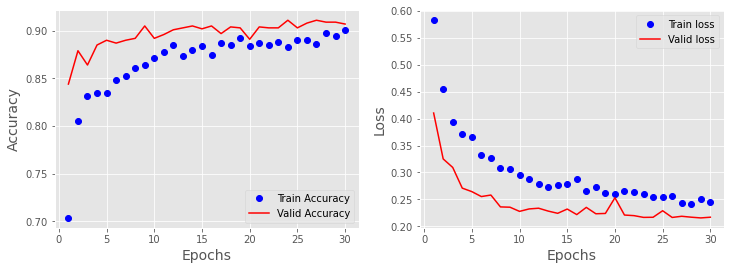

In [18]:
## Visualize the resutls
n_epochs = len(history_extract_aug.history['accuracy'])

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history_extract_aug.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history_extract_aug.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history_extract_aug.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history_extract_aug.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [22]:
## evaluating on test set
loss_test, acc_test = model_extract_aug.evaluate_generator(test_gen)
print('loss_test -->', loss_test)
print('acc_test -->', acc_test)

loss_test --> 0.2164728343486786
acc_test --> 0.9120000004768372


In [24]:
## save the model ---> (Feature Extraction wit h Augmentation)
model_extract_aug.save('vgg16_withAugmentation.h5')

### Fine-Tuning a pre-trained Model

`Let's tune only three final convolution layers VGG16 --> from | block5_conv1 (Conv2D) `

In [51]:
## check the VGG16
conv_base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [52]:
## Build a Model but add the conv_base to it

model_tuned = tf.keras.models.Sequential([
                        conv_base_vgg16,    ## Add the conv_base
                        ## Do not forget to flatten
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(256, activation='relu'),
                        tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tuned.summary()  ## very nice

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [53]:
## we should unfreeze the 3 layers and train the model
conv_base_vgg16.trainable = True     ## unfreeze all , then will be handled in the below code

set_trainable = False
for layer in conv_base_vgg16.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        


## chek that you made them trainable
traiable_layers_vgg = [layer.name for layer in model_tuned.get_layer('vgg16').layers 
                                       if layer.trainable==True]

print('traiable_layers_vgg -->', traiable_layers_vgg)

traiable_layers_vgg --> ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [54]:
## train the model
model_tuned.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), 
                      metrics=['accuracy'])

## Here Generator ---> it will loop forever --> specity steps for training and validation
history_tuned = model_tuned.fit(train_gen, validation_data=(valid_gen), 
                                steps_per_epoch=100, validation_steps=50,
                                epochs=30, batch_size=20)

Epoch 1/30
100/100 [==============================] - 24s 231ms/step - loss: 0.5235 - accuracy: 0.7455 - val_loss: 0.3423 - val_accuracy: 0.8470
Epoch 2/30
100/100 [==============================] - 22s 219ms/step - loss: 0.3408 - accuracy: 0.8535 - val_loss: 0.2218 - val_accuracy: 0.9050
Epoch 3/30
100/100 [==============================] - 22s 218ms/step - loss: 0.2938 - accuracy: 0.8770 - val_loss: 0.1976 - val_accuracy: 0.9130
Epoch 4/30
100/100 [==============================] - 21s 214ms/step - loss: 0.2787 - accuracy: 0.8865 - val_loss: 0.1835 - val_accuracy: 0.9120
Epoch 5/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2323 - accuracy: 0.9025 - val_loss: 0.1798 - val_accuracy: 0.9130
Epoch 6/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2220 - accuracy: 0.9035 - val_loss: 0.1761 - val_accuracy: 0.9200
Epoch 7/30
100/100 [==============================] - 22s 216ms/step - loss: 0.1964 - accuracy: 0.9140 - val_loss: 0.1685 - val_ac

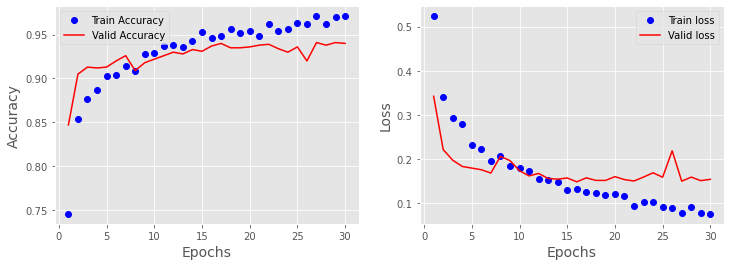

In [55]:
## Visualize the resutls
n_epochs = len(history_tuned.history['accuracy'])

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history_tuned.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history_tuned.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history_tuned.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history_tuned.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [57]:
## evaluating on test set
loss_test, acc_test = model_tuned.evaluate_generator(test_gen)
print('loss_test -->', loss_test)
print('acc_test -->', acc_test)

loss_test --> 0.18077318370342255
acc_test --> 0.9470000267028809


In [58]:
## Save that Tuned Model
model_tuned.save('vgg16_finetuned.h5')

### Done!